In [236]:
pd. set_option('display.max_columns', 1000)
pd. set_option('display.max_rows', 1000) 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from pylab import rcParams
import datetime


plt.rcParams['figure.figsize'] = 18,8
pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

import sklearn
from sklearn import preprocessing


from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

In [237]:
df_holiday = pd.read_csv(r"D:\AI_Assignment\holidays_events.csv")
df_oil = pd.read_csv(r"D:\AI_Assignment\oil.csv",index_col = "date")
df_train = pd.read_csv(r"D:\AI_Assignment\train.csv")
df_stores = pd.read_csv(r"D:\AI_Assignment\stores.csv")
df_transaction = pd.read_csv(r"D:\AI_Assignment\transactions.csv")
df_test = pd.read_csv(r"D:\AI_Assignment\test.csv")

In [239]:
#combining all the dataframes into 1
df_train1 = df_train.merge(df_holiday, on = 'date', how='left')
df_train1 = df_train1.merge(df_oil, on = 'date', how='left')
df_train1 = df_train1.merge(df_stores, on = 'store_nbr', how='left')
df_train1 = df_train1.merge(df_transaction, on = ['date', 'store_nbr'], how='left')
df_train1 = df_train1.rename(columns = {"type_x" : "holiday_type", "type_y" : "store_type"})

#changing the datatype of columns
df_train1['date'] = pd.to_datetime(df_train1['date'])
df_train1['year'] = df_train1['date'].dt.year
df_train1['month'] = df_train1['date'].dt.month
df_train1['week'] = df_train1['date'].dt.isocalendar().week
df_train1['quarter'] = df_train1['date'].dt.quarter
df_train1['day_of_week'] = df_train1['date'].dt.day_name()

In [240]:
#checking for missing values in all datasets
print(df_train.isna().sum())
print(df_test.isna().sum())
print(df_holiday.isna().sum())
print(df_transaction.isna().sum())
print(df_oil.isna().sum())
print(df_stores.isna().sum())

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
date            0
store_nbr       0
transactions    0
dtype: int64
dcoilwtico    43
dtype: int64
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [241]:
#as oil prices data has Nan values we will deal with them
#As the missing values are not on oil trading holidays, it is assumed that there might be fluctuations in the prices.
#As the first row does not have any previous data to interpolate, the oil price of the next day is set to it
df_oil.iloc[0] = df_oil.iloc[1]
#fixing the remaining nan values by interpolating
df_oil = df_oil.interpolate(method='linear')

In [157]:
print(df_oil.isna().sum())

dcoilwtico    0
dtype: int64


In [158]:
#checking the datatypes of columns
df_train.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [159]:
#checking the datatypes of columns
df_test.dtypes

id              int64
date           object
store_nbr       int64
family         object
onpromotion     int64
dtype: object

In [160]:
#converting date object to datetime to create columns of year, day and month easily
df_test.date= pd.to_datetime(df_test.date)
df_test['year'] = df_test.date.dt.year
df_test['month'] = df_test.date.dt.month
df_test['dayofmonth'] = df_test.date.dt.day
df_test['dayofweek'] = df_test.date.dt.dayofweek
df_test['dayname'] = df_test.date.dt.strftime('%A')

In [161]:
#getting the start and end date of training and test data
print('Train: ',min(df_train1.date),max(df_train.date))
print('Test: ',min(df_test.date),max(df_test.date))
#the objective is to forcast for 15 days after the end of the training data

Train:  2013-01-01 00:00:00 2017-08-15
Test:  2017-08-16 00:00:00 2017-08-31 00:00:00


In [162]:
#getting all the families of products sold in the stores
df_train1.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [163]:
#getting the total number of product families
len(df_train1.family.unique())

33

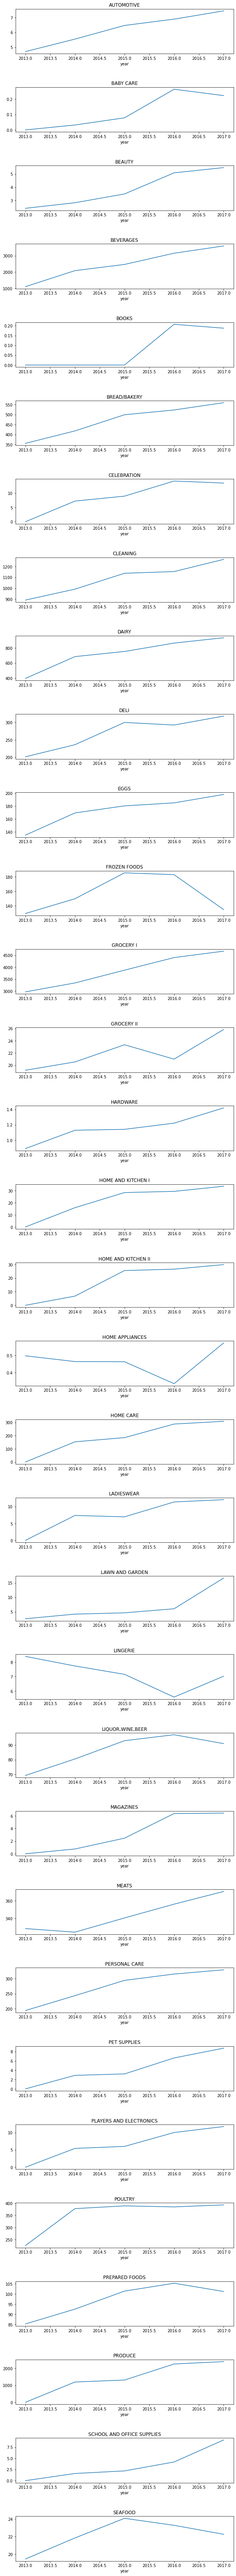

In [164]:
#plotting the trend of sales of product families over the years
import matplotlib.pyplot as plt 

fig= plt.figure(figsize=(10,120))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(df_train.family.unique()):
    ax = fig.add_subplot(33,1,i+1)
    df_train1.query('family==@product').groupby(['year']).sales.mean().plot()
    plt.title(product)

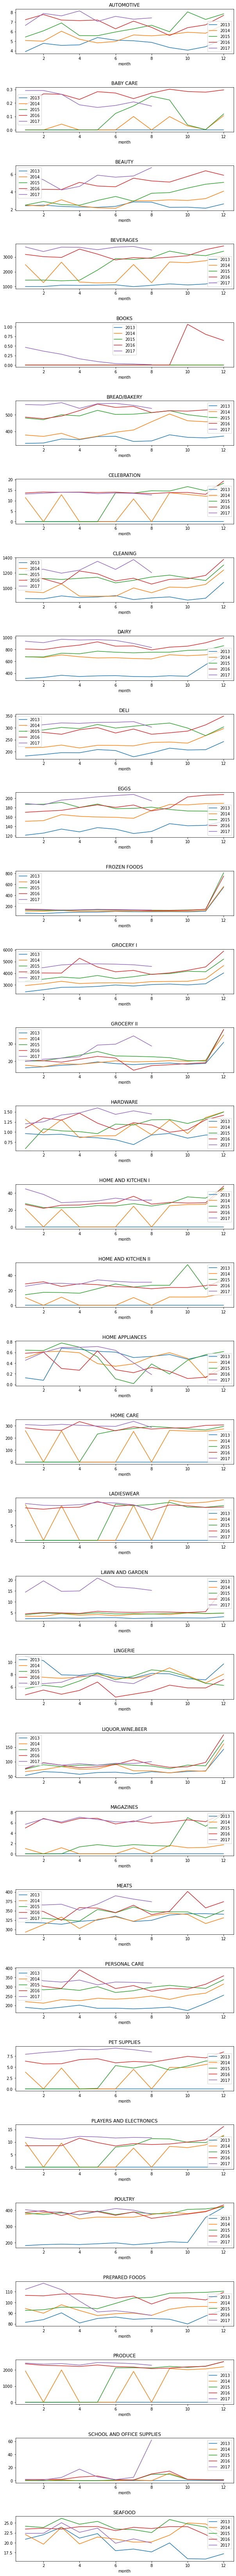

In [165]:
#To better understand seasonality, each family sales is plotted for each monthe over a year
fig= plt.figure(figsize=(10,120))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(df_train1.family.unique()):
    ax = fig.add_subplot(33,1,i+1)
    select = df_train1.query('family==@product')
    for year in [2013,2014,2015,2016,2017]: 
        select.query('year==@year').groupby('month').sales.mean().plot(ax=ax,label=year)
    plt.title(product)
    ax.legend();

In [166]:
df_train1.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion',
       'holiday_type', 'locale', 'locale_name', 'description', 'transferred',
       'dcoilwtico', 'city', 'state', 'store_type', 'cluster', 'transactions',
       'year', 'month', 'week', 'quarter', 'day_of_week'],
      dtype='object')

Text(0.5, 1.0, 'Sales Average by Day of Month')

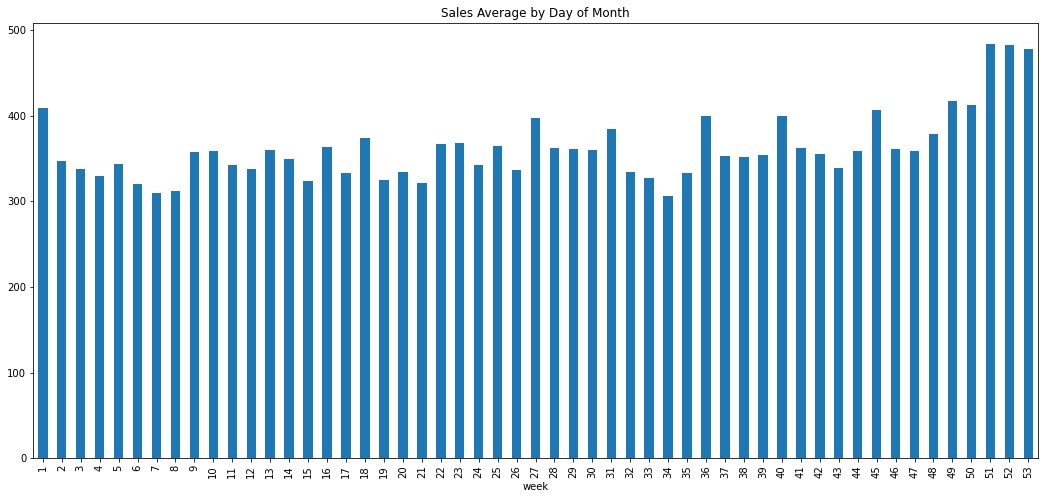

In [167]:
#checking to see if there exists seasonality in a month as the wages are paid twice a month on the 15th and the 30th
df_train1.groupby('week').sales.mean().plot(kind='bar')
plt.title('Sales Average by Day of Month')

Text(0.5, 1.0, 'Average Sales by Day of week')

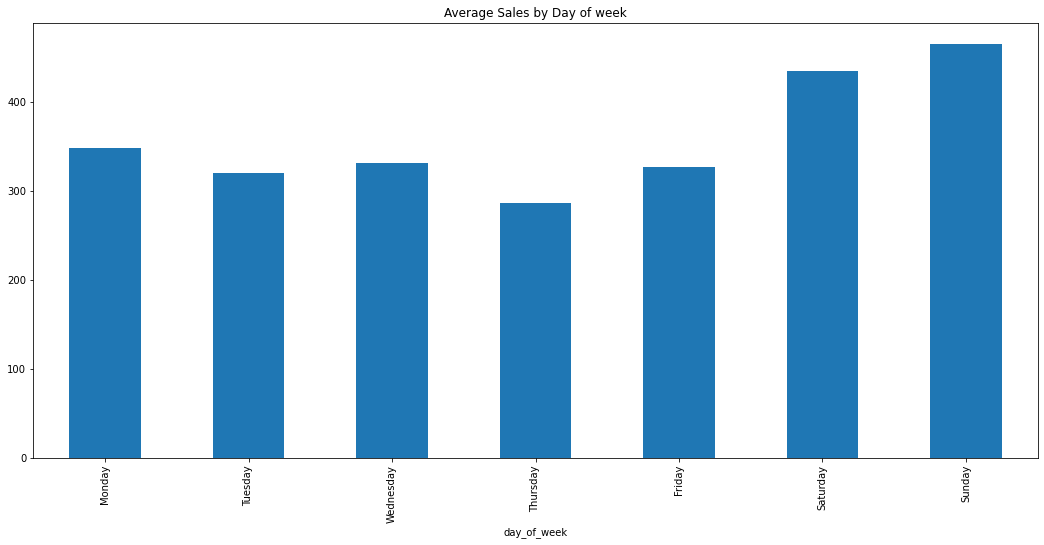

In [168]:
#checking to see if there are variations over the week in sales as people might shop on weekends
order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df_train1.groupby('day_of_week').sales.mean().reindex(index=order).plot(kind='bar')
plt.title('Average Sales by Day of week')

Text(0.5, 1.0, 'Sales Ranking by Store')

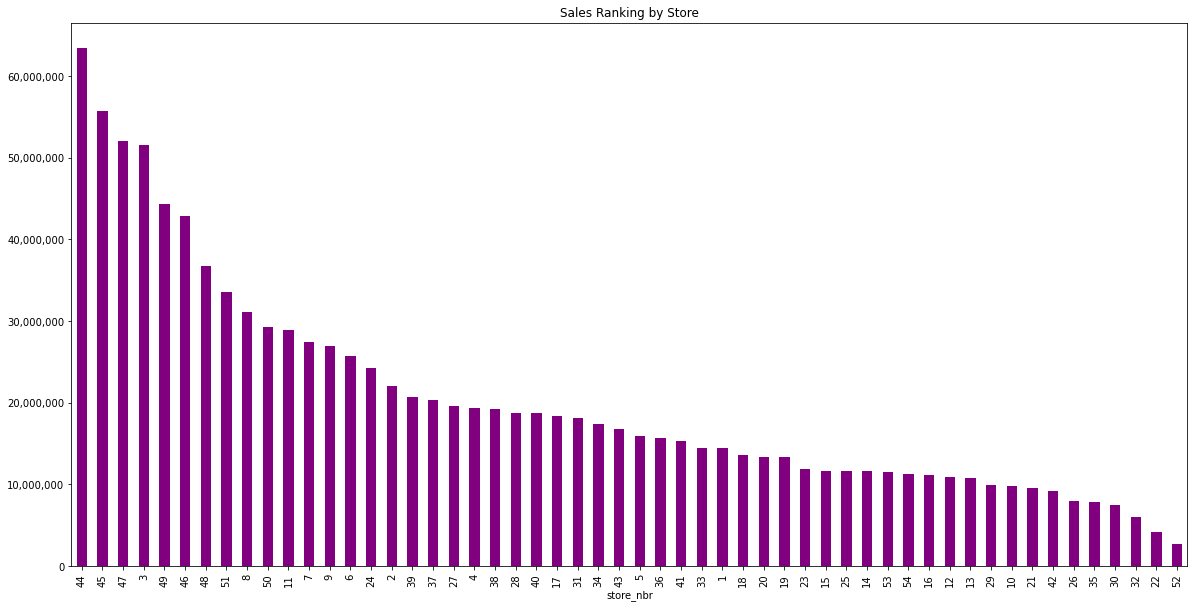

In [169]:
import matplotlib
#checking to see what stores have the highest sales
plt.figure(figsize=(20,10))
#adding format to the y axis
df_train1.groupby('store_nbr').sales.sum().sort_values(ascending=False).plot(kind='bar',color = 'purple').get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Sales Ranking by Store')

Text(0.5, 1.0, 'Promotion Items Ranking by Store')

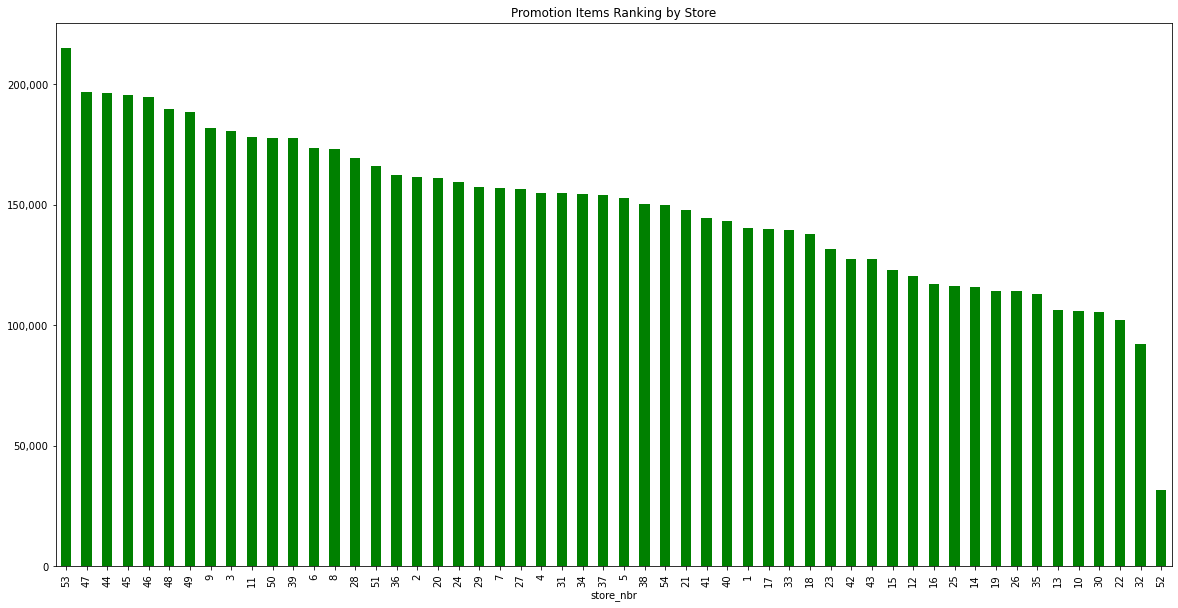

In [170]:
#Checking the number of promotions per store
plt.figure(figsize=(20,10))
df_train1.groupby('store_nbr').onpromotion.sum().sort_values(ascending=False).plot(kind='bar',color='green').get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Promotion Items Ranking by Store')

Text(0.5, 1.0, 'Promotion and Sales Relationship')

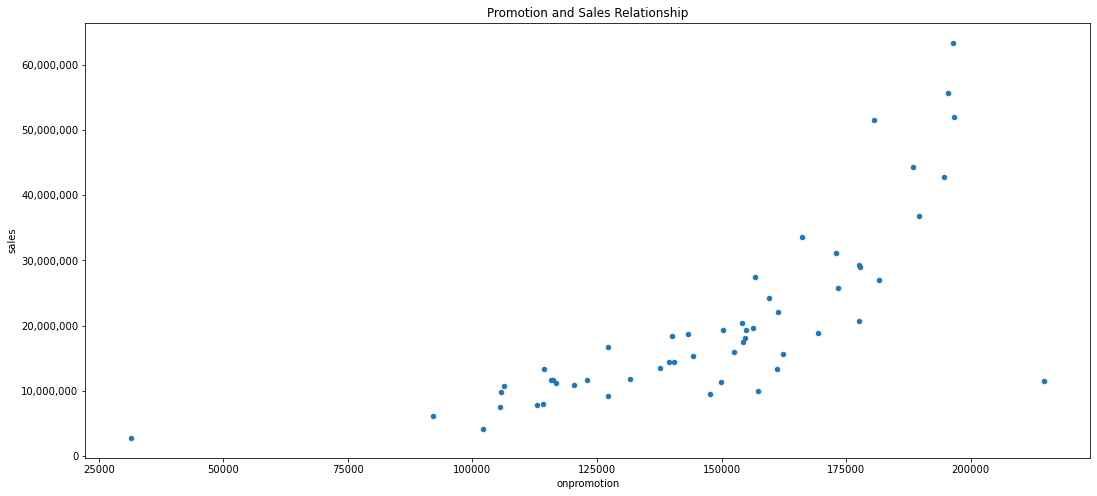

In [171]:
#checking the correlation between promotion and sales
df_train1.groupby('store_nbr')[['onpromotion','sales']].sum().plot.scatter('onpromotion','sales').get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.title('Promotion and Sales Relationship')

In [175]:
#Few data are missing from the oil data as the training data has 1700 dats and oil data has 1218 days
#df_oil.set_index('date').dcoilwtico.plot()

In [176]:
df_train = pd.merge(df_train,df_stores,how='left',on='store_nbr')
df_test = pd.merge(df_test,df_stores,how='left',on='store_nbr')

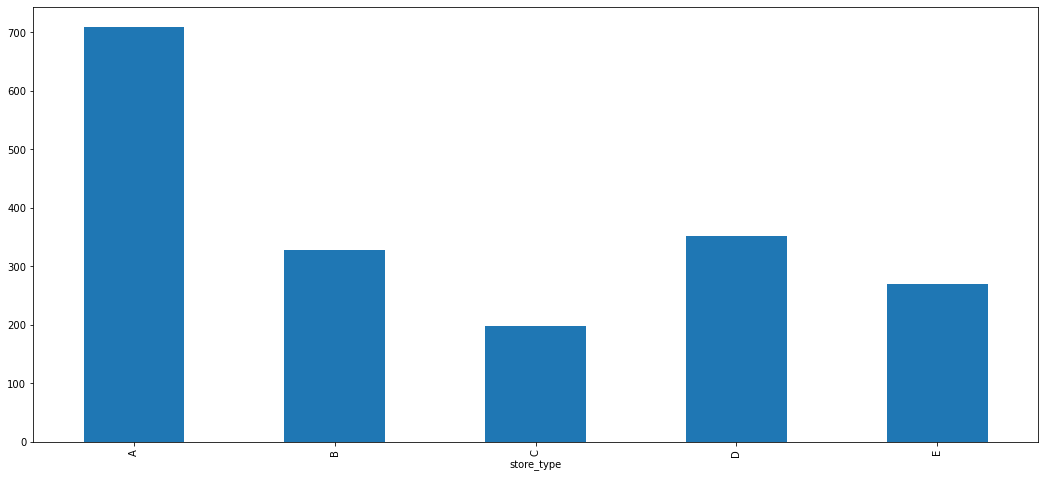

In [178]:
#checking what type of store has the largest sales
df_train1.groupby(['store_type']).sales.mean().plot(kind='bar');

Text(0.5, 1.0, 'Number of Stores by City')

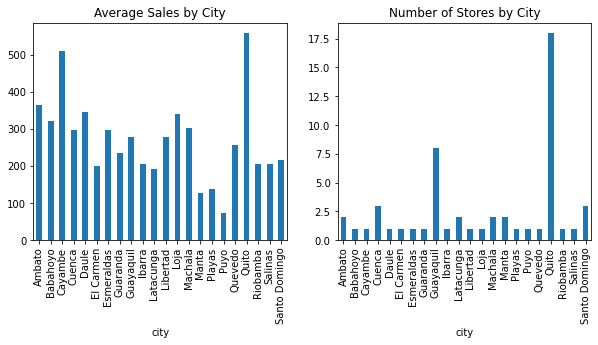

In [179]:
#Getting the average sales per city and number of stores per city
plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
df_train1.groupby(['city']).sales.mean().plot(kind='bar')
plt.title('Average Sales by City')
ax2 = plt.subplot(1,2,2)
df_train1.groupby(['city'])['store_nbr'].nunique().plot(kind='bar')
plt.title('Number of Stores by City')

<AxesSubplot:xlabel='cluster'>

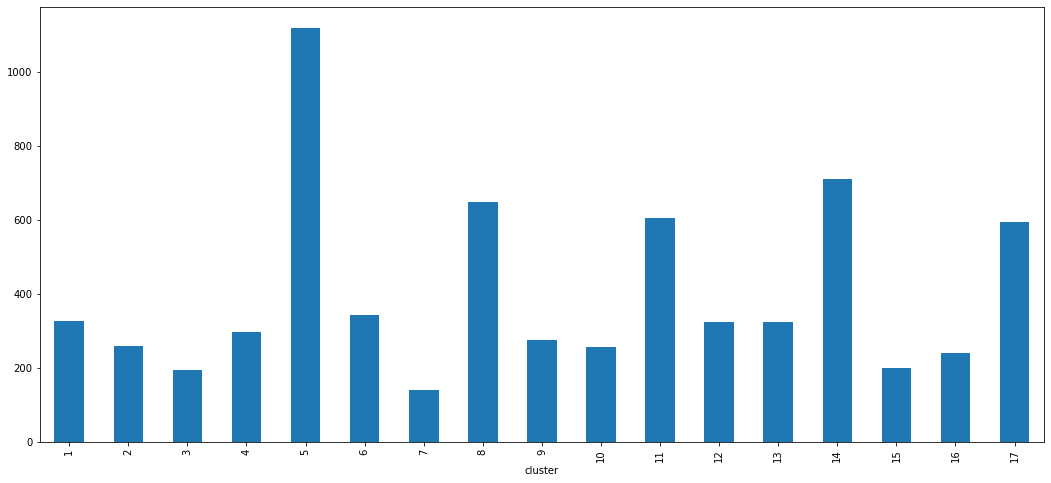

In [180]:
#sales and number of clusters relationship
df_train1.groupby(['cluster']).sales.mean().plot(kind='bar')

In [181]:
df = df_train1 #copying the original df into a temp df which we can work on,just incase we dont mess up with the original one
df['date'] = df['date'].dt.floor('d')
#Creating a dataframe with only sales and date
df = df[['date', 'sales']]
#setting the date column as index
df = df.set_index(df.date)
df.drop('date', axis=1, inplace=True)
df = df.resample('M').mean()

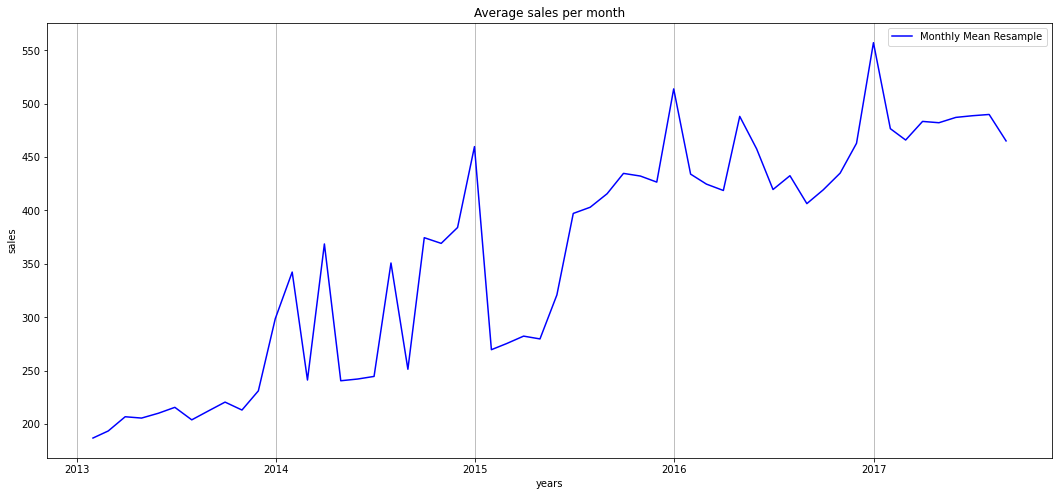

In [182]:
y = df['sales']
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y, label='Monthly Mean Resample', color='blue')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend();

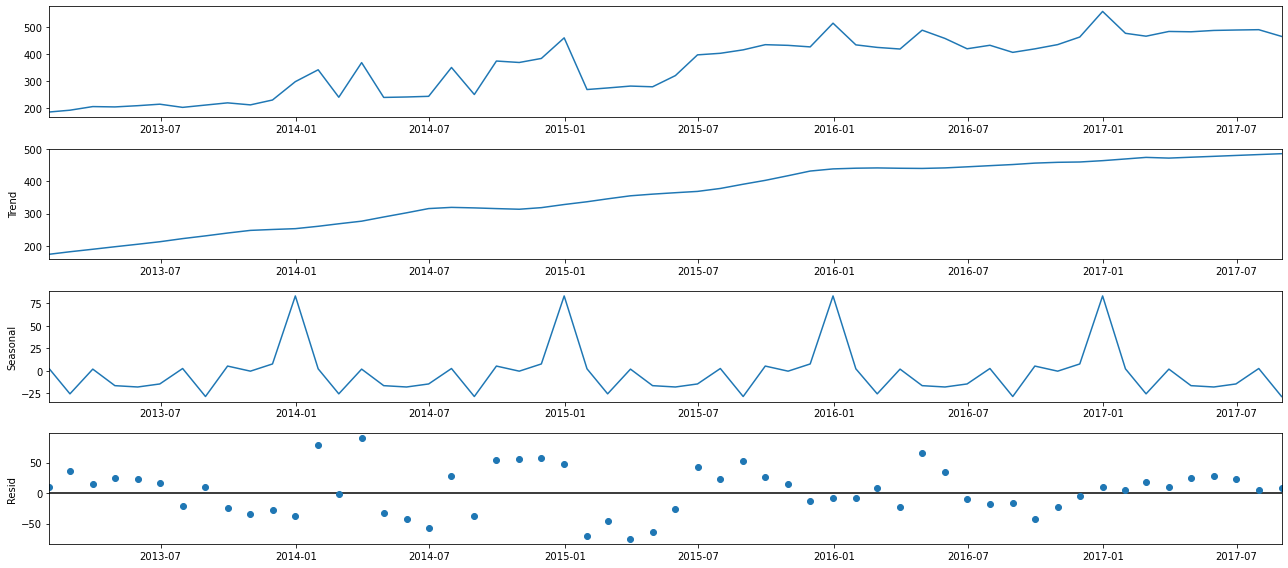

In [183]:
#Decomposition plots
df_dec=seasonal_decompose(df,model='additive', extrapolate_trend='freq')
df_dec.plot();

In [184]:
#Testing for stationarity
dftest = adfuller(df.dropna(), autolag='AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('P-value = {:.3f}'.format(dftest[1]))
print('Critical values :')
for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

Test statistic = -1.582
P-value = 0.493
Critical values :
	1%: -3.55770911573439 - The data is not stationary with 99% confidence
	5%: -2.9167703434435808 - The data is not stationary with 95% confidence
	10%: -2.59622219478738 - The data is not stationary with 90% confidence


In [185]:
#making the data stationary
df_lag12 = df.sales - df.sales.shift(12)

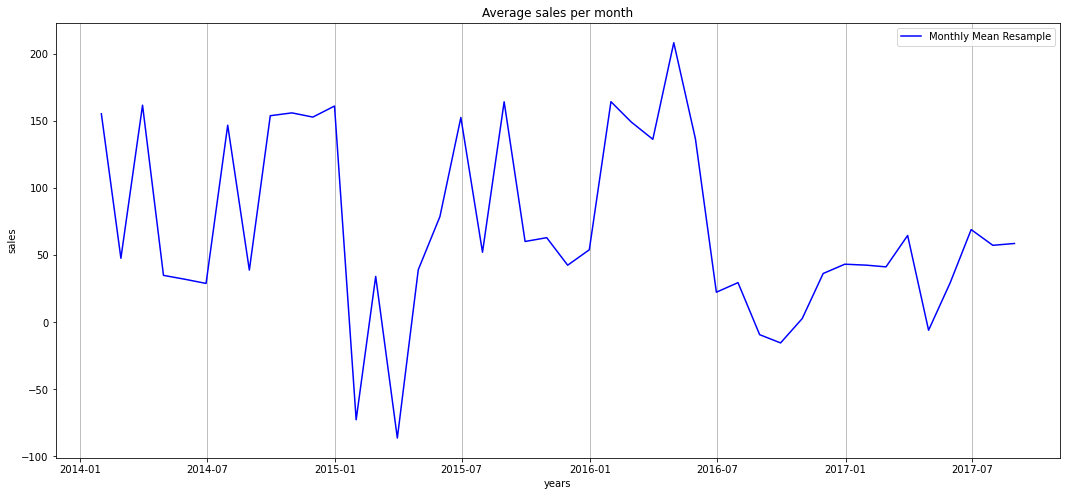

In [186]:
y = df_lag12
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,label='Monthly Mean Resample', color='blue')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend();

In [187]:
#checking for stationarity again
dftest = adfuller(df_lag12.dropna(), autolag='AIC')
print('Test statistic = {:.3f}'.format(dftest[0]))
print('P-value = {:.3f}'.format(dftest[1]))
print('Critical values :')
for k, v in dftest[4].items():
    print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

Test statistic = -3.734
P-value = 0.004
Critical values :
	1%: -3.6055648906249997 - The data is  stationary with 99% confidence
	5%: -2.937069375 - The data is  stationary with 95% confidence
	10%: -2.606985625 - The data is  stationary with 90% confidence


NAIVE MODEL

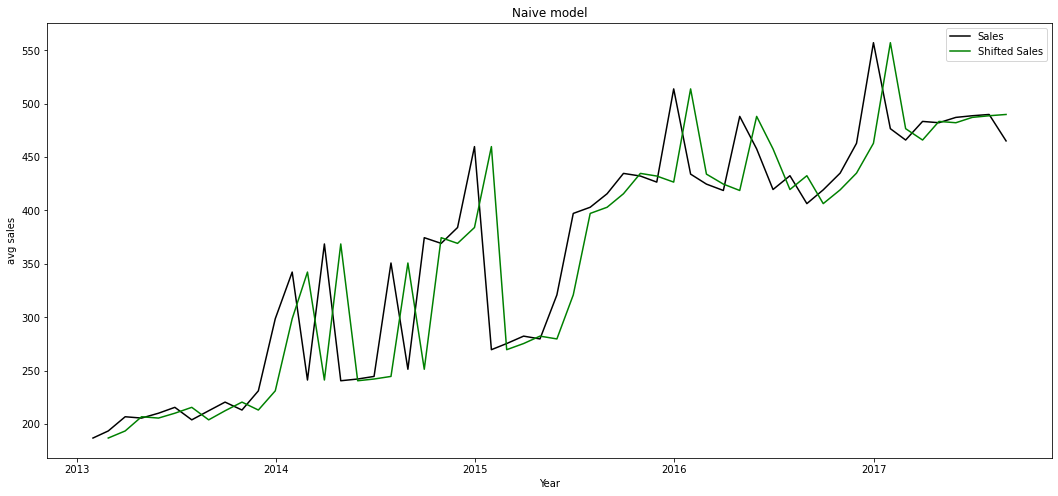

In [188]:
#creating a naive model
df['shifted_sales'] = df.sales.shift(1)
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df.sales, label='Sales',color='black')
ax.plot(df.shifted_sales,label='Shifted Sales', color='green');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('Naive model')
ax.legend()
plt.show()

In [189]:
#Getting the evaluation metric of the naive model
df = df.dropna()
mse = mean_squared_error(df.sales, df.shifted_sales)
rmse = np.sqrt(mse)
print(f'The root mean square error of the naive model is : {rmse}')

The root mean square error of the naive model is : 56.6802923750903


# Holt-Winters model

In [190]:
#building the model
df = df.drop('shifted_sales',axis=1) # 'shifted_sales' is redundant for holt-winters model
hw = ExponentialSmoothing(df, seasonal_periods=12,trend='add', seasonal='add').fit()
hw_preds = hw.forecast(steps=24)

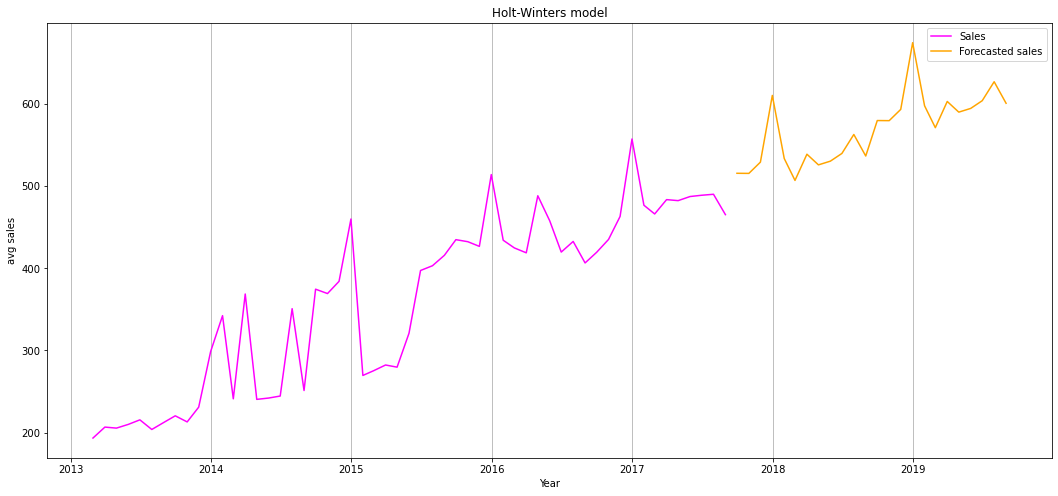

In [191]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df, label='Sales',color='fuchsia')
ax.plot(hw_preds, label='Forecasted sales', color='orange');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('Holt-Winters model' )
ax.grid(axis='x')
ax.legend()
plt.show()


In [192]:
#Obtaining the evaluation metrics
hw_resid = hw.resid
hw_resid_sqr = np.square(hw_resid)
hw_resid_mse = hw_resid_sqr.sum()/len(hw_resid_sqr)
hw_resid_rmse = np.sqrt(hw_resid_mse)
print(f'The rmse value of Holt-Winters model is {hw_resid_rmse}')

The rmse value of Holt-Winters model is 38.352901681099354


In [193]:
dftrain = df.iloc[:38]
dftest = df.iloc[38:]

# Autoregressive Integrated Moving Average (ARIMA)

In [194]:
#building the model
arima_mod = sm.tsa.arima.ARIMA(dftrain, order=(4,2,4)) #p=5, d=1, q=3
arima_mod= arima_mod.fit()
arima_preds = arima_mod.forecast(steps = 17)

In [195]:
#getting the evaluation metrics
mse = mean_squared_error(dftest, arima_preds)
print(f'The root mean square error of ARIMA with (4,2,4) is {np.sqrt(mse)}')

The root mean square error of ARIMA with (4,2,4) is 36.23691671212719


In [196]:
arima_preds = pd.Series(arima_preds, index=dftest.index)

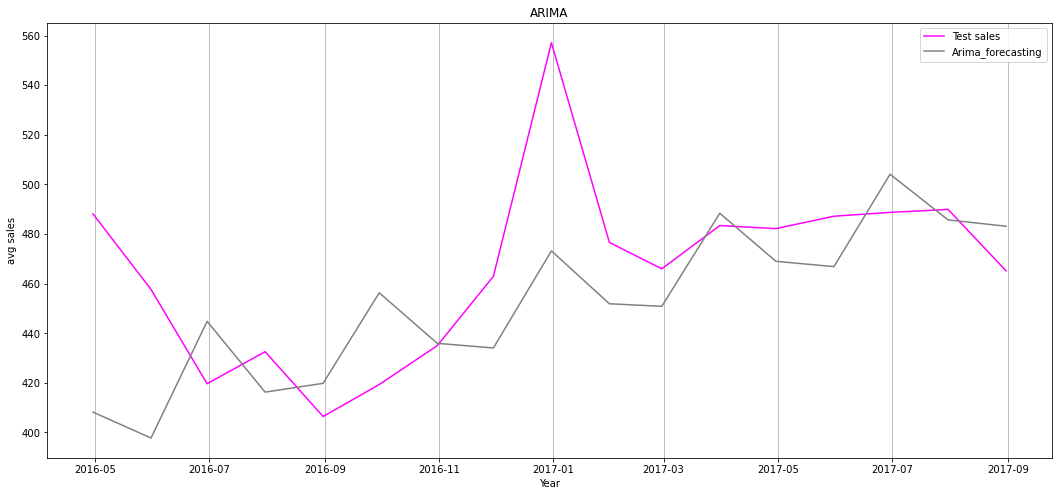

In [197]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(dftest, label='Test sales', color='fuchsia');
ax.plot(arima_preds, label='Arima_forecasting', color='grey');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('ARIMA' )
ax.grid(axis='x')
ax.legend()
plt.show()